## ROADMAP

- [x] years in company vs salary vs sex
- [x] experience vs salary vs sex
- [x] outliers
- [x] clean (bin) position
- [x] clean (bin) geography
- [ ] clean (bin) industry (design vs dev vs .. )
- [ ] correlations
- [ ] model
- [ ] report

In [1]:
import pandas as pd
import numpy as np

%pylab inline
import matplotlib.pyplot as plt
from ipynotifyer import notifyOnComplete as nf

import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# # recent
path = 'https://dl.dropboxusercontent.com/u/7604347/Зарплаты%20-%20Form%20responses%201.csv'
df = pd.read_csv(path, encoding='utf8')
# df.to_csv('data/recent_salaries.csv', encoding='utf8')

In [3]:
# df = pd.read_csv('data/2016_04_9_salaries.csv', encoding='utf8')

In [4]:
len(df)

639

## Rename columns

In [5]:
df.columns

Index([u'Timestamp', u'Работодатель', u'Город', u'Должность', u'Обязанности',
       u'Стаж в компании (лет)', u'Профессиональный стаж (лет)',
       u'Укажите вашу зарплату со всеми нулями (!) в месяц в валюте, которую вы выбрали выше (после вычета налогов)',
       u'Ежемесячный бонус в валюте, которую вы выбрали выше',
       u'Годовая премия в валюте, которую вы выбрали выше', u'Пол',
       u'Комментарий', u'Выберите в какой валюте вы получаете зарплату.'],
      dtype='object')

In [6]:
df.columns = ('ts','company','city','position',
              'job', 'Yexp', 'Pexp', 'salary',
              'mBonus', 'yBonus','gender','coment',
             'currency')

In [7]:
df.head(2)

,ts,company,city,position,job,Yexp,Pexp,salary,mBonus,yBonus,gender,coment,currency
0,22/03/2016 19:06:07,NaN,NaN,Дизайнер мобильных приложений,iOS & Android,1.55,5,130000,NaN,NaN,Мужчина,NaN,Рубли
1,22/03/2016 19:06:46,NaN,Санкт-Петербург,Дизайнер интерфейсов,"Интерфейсы для веба, визуализация данных",0.25,4,80000,NaN,NaN,Мужчина,NaN,Рубли


## Income

In [8]:
df.currency.value_counts()

Рубли      539
Доллары    100
Name: currency, dtype: int64

In [9]:
def Yincome(x):
    '''
    total year income,
    using 1$ = 70rub,
    in rubles
    '''
    income = 12*(x.salary + x.mBonus) + x.yBonus
    
    if x.currency == u'Доллары':
#         print '$$$'
        income = income * 70
    
    return income   

In [10]:
for key in ('yBonus','mBonus','salary','Yexp','Pexp'):
    df[key] = pd.to_numeric(df[key], errors='coerse').fillna(0)


In [11]:
df['income'] = df.apply(Yincome, 1)

## Gender

In [12]:
gender = {u'Мужчина':'male', u'Женщина':'female' }
df['gender'] = df['gender'].apply(lambda x: gender.get(x, None))

In [13]:
len(df)

639

## Geography

In [14]:
df['city'] = df['city'].str.lower()
df['city'].value_counts().head(10)

москва             267
санкт-петербург     67
ростов-на-дону      18
moscow              13
казань              13
новосибирск         13
екатеринбург        12
киев                11
минск               11
воронеж              7
Name: city, dtype: int64

In [15]:
path = 'data/2016_04_09_CR_Salaries.xlsx'
geography = pd.read_excel(path, sheetname=1)[[u'raw', u'город', u'регион']]
geography.columns = ['raw','city','reg']
geography = geography[geography.city != 'uk']
geography.head(2)

,raw,city,reg
0,минск,Minsk,Belorus
2,almaty,Almaty,Russia


In [16]:
len(df)

639

In [17]:
geography.reg.value_counts()

Russia          65
Ukraine         15
Moscow           9
Europe           7
Belorus          5
StPetersburg     4
US               3
ME               2
?                2
Asia             1
Uzbekistan       1
Name: reg, dtype: int64

In [18]:
df = df.merge(geography, how='left', left_on='city',right_on='raw')
df.drop('raw', 1, inplace=1)

In [19]:
df.reg.value_counts()

Moscow          294
Russia          153
StPetersburg     74
Ukraine          34
Belorus          17
Europe            7
US                3
?                 2
ME                2
Uzbekistan        1
Asia              1
Name: reg, dtype: int64

In [20]:
len(df)

639

## Position

In [21]:
proff = pd.read_excel(path, header=None, sheetname=2)
proff.columns = ['raw','do','','level','industry',None, None]
proff = proff[['raw','level','industry']]
proff.industry = proff.industry.str.lower()
proff.head(4)

,raw,level,industry
0,юрист,norm,loyer
1,-,norm,NaN
2,.NET разработчик,norm,web-dev
3,3d artist,norm,cg


## Industry

In [22]:
ind = {
        'design' : [
        'ux_design',
        'g_design',
        'web_design',
        'product_design',
        'graphic_design',
        'web-design',
        'cg',
        'graph_design',
        'app_design',
        'game_designer',
        'design',
        'video'
    ],

    'dev' : [
        'dev',
        'web_dev',
        'app_dev',
        'engineer',
        'sys',
        'front-dev',
        'web-dev'
    ],

    'management' : [
        'management',
        'sales',
        'analysis',
        'marketing',
        'analyst',
        'manager',
        'account',
        'accounting',
        'analytics'
    ],

    'other' :  [
        'content',
        'academia',
        'pr',
        'layer',
        'hr',
        'buyer',
        'loyer'
    ]
}

def getIndustry(x):
    '''
    retrieve industry by raw cat
    '''
    for k, v in ind.iteritems():
        if x in v:
            return k
    return None


proff['ind'] = proff.industry.apply(getIndustry)

In [23]:
len(df)

639

In [24]:
proff.ind.value_counts()

design        350
management    131
dev           124
other          35
Name: ind, dtype: int64

In [25]:
proff.drop_duplicates(subset=('raw',), inplace=1)

In [26]:
df = df.merge(proff[['raw', 'ind']], how='left', left_on='position',right_on='raw')
df.drop('raw', 1, inplace=1)

In [27]:
len(df)

639

In [28]:
df.head(2)

,ts,company,city_x,position,job,Yexp,Pexp,salary,mBonus,yBonus,gender,coment,currency,income,city_y,reg,ind
0,22/03/2016 19:06:07,NaN,NaN,Дизайнер мобильных приложений,iOS & Android,1.55,5,130000,0,0,male,NaN,Рубли,1560000,NaN,NaN,design
1,22/03/2016 19:06:46,NaN,санкт-петербург,Дизайнер интерфейсов,"Интерфейсы для веба, визуализация данных",0.25,4,80000,0,0,male,NaN,Рубли,960000,StPetersburg,StPetersburg,design


## Final tune

In [29]:
df.city_y.replace('Kyiv','Kiev', inplace=1)
df.gender.replace('unknown', np.nan, inplace=1)

In [33]:
df.to_csv('data/processed.csv', encoding='utf8')

## Draft  Analysis

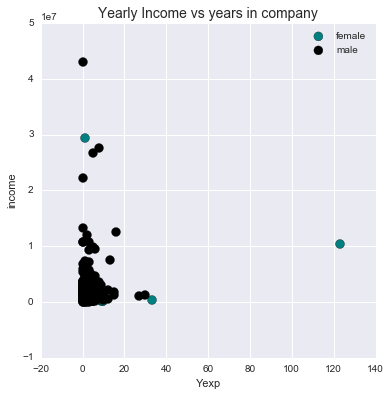

In [31]:
fig, ax = plt.subplots(figsize=(6,6))

for i, (name, g) in enumerate(df.groupby('gender')):
    col = ('teal','black','red')[i]
    g.plot(kind='scatter', x='Yexp', y='income', ax=ax, c=col, label=name, s=80);

plt.legend()
plt.title('Yearly Income vs years in company', fontsize = 14);

### 120 years of experience? 30'000'000 roubles a year?
### we need to get rid of those outliers

hardcoding for now

In [ ]:
# income less than ten millions, experience less than a year
df1 = df[(df.income < 10000000)&(df.Yexp < 50)&(df.Pexp < 50)]

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

for i, (name, g) in enumerate(df1.groupby('gender')):
    col = ('teal','black','red')[i]
    g.plot(kind='scatter', x='Yexp', y='income', ax=ax, c=col, label=name, alpha=.5, s=80);

plt.legend()
plt.title('Yearly Income vs years in company', fontsize = 14);

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

for i, (name, g) in enumerate(df1.groupby('gender')):
    col = ('teal','black','red')[i]
    g.plot(kind='scatter', x='Pexp', y='income', ax=ax, c=col, label=name, alpha=.5, s=80);

plt.legend()
plt.title('Yearly Income vs years of experience', fontsize = 14);

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

for i, (name, g) in enumerate(df1.groupby('gender')):
    col = ('teal','black','red')[i]
    g.plot(kind='scatter', x='Pexp', y='Yexp', ax=ax, c=col, label=name, alpha=.5, s=80);

plt.legend()
plt.title('years in company vs years of experience', fontsize = 14);